# SIAMESE-NETWORK

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/BTP/siamese-network/

/content/drive/MyDrive/BTP/siamese-network


In [139]:
import os
import cv2
import zipfile
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime
from sklearn.utils import shuffle
from tensorflow import keras
import shutil
import dlib
from imutils import face_utils
from google.colab.patches import cv2_imshow

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [98]:
if os.path.isdir('dataset/images'):
  # shutil.rmtree('dataset/images')
  pass
else:
  # !unzip dataset/images.zip -d dataset/
  with zipfile.ZipFile('dataset/images.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/')


Archive:  dataset/images.zip
   creating: dataset/images/
   creating: dataset/images/n000009/
  inflating: dataset/images/n000009/0122_01.jpg  
  inflating: dataset/images/n000009/0248_01.jpg  
  inflating: dataset/images/n000009/0188_01.jpg  
  inflating: dataset/images/n000009/0175_01.jpg  
  inflating: dataset/images/n000009/0027_01.jpg  
  inflating: dataset/images/n000009/0016_01.jpg  
  inflating: dataset/images/n000009/0102_01.jpg  
  inflating: dataset/images/n000009/0053_01.jpg  
  inflating: dataset/images/n000009/0011_01.jpg  
  inflating: dataset/images/n000009/0269_01.jpg  
  inflating: dataset/images/n000009/0021_01.jpg  
  inflating: dataset/images/n000009/0258_01.jpg  
  inflating: dataset/images/n000009/0003_01.jpg  
  inflating: dataset/images/n000009/0120_01.jpg  
  inflating: dataset/images/n000009/0246_01.jpg  
  inflating: dataset/images/n000009/0243_01.jpg  
  inflating: dataset/images/n000009/0108_01.jpg  
  inflating: dataset/images/n000009/0015_01.jpg  
  inf

In [133]:
epochs = 50

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00006)
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

# base_dir = "."
base_dir = "/content/drive/MyDrive/BTP/siamese-network/"

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(base_dir, 'logs/func/%s' % stamp)
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = os.path.join(base_dir, 'logs/scalars/%s' % stamp)
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

checkpoint_path = os.path.join(base_dir, 'logs/model/siamese-1')

In [6]:
'''
The following code cell is taken from the source code of keras_vggface.
I tried using the preprocess_input function provided by tf.keras but they provide different results.
To my knowledge, it seems that the mean values which are subtracted in each image are different.
'''
K = tf.keras.backend

def preprocess_input(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp

In [99]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset_path, batch_size=32, shuffle=True):
        self.dataset = self.curate_dataset(dataset_path)
        self.dataset_path = dataset_path
        self.shuffle = shuffle
        self.batch_size =batch_size
        self.no_of_people = len(list(self.dataset.keys()))
        self.on_epoch_end()
        
    def __getitem__(self, index):
        people = list(self.dataset.keys())[index * self.batch_size: (index + 1) * self.batch_size]
        P = []
        A = []
        N = []
        
        for person in people:
            anchor_index = random.randint(0, len(self.dataset[person])-1)
            a = self.get_image(person, anchor_index)
            
            positive_index = random.randint(0, len(self.dataset[person])-1)
            while positive_index == anchor_index:
                positive_index = random.randint(0, len(self.dataset[person])-1)
            p = self.get_image(person, positive_index)
            
            negative_person_index = random.randint(0, self.no_of_people - 1)
            negative_person = list(self.dataset.keys())[negative_person_index]
            while negative_person == person:
                negative_person_index = random.randint(0, self.no_of_people - 1)
                negative_person = list(self.dataset.keys())[negative_person_index]
            
            negative_index = random.randint(0, len(self.dataset[negative_person])-1)
            n = self.get_image(negative_person, negative_index)
            P.append(p)
            A.append(a)
            N.append(n)
        A = np.asarray(A)
        N = np.asarray(N)
        P = np.asarray(P)
        return [A, P, N]
        
    def __len__(self):
        return self.no_of_people // self.batch_size
        
    def curate_dataset(self, dataset_path):
        with open(os.path.join(dataset_path, 'list.txt'), 'r') as f:
            dataset = {}
            image_list = f.read().split()
            print('Total images: ',len(image_list))
            for image in image_list:
                folder_name, file_name = image.split('/')
                if folder_name in dataset.keys():
                    dataset[folder_name].append(file_name)
                else:
                    dataset[folder_name] = [file_name]
        return dataset
    
    def on_epoch_end(self):
        if self.shuffle:
            keys = list(self.dataset.keys())
            random.shuffle(keys)
            dataset_ =  {}
            for key in keys:
                dataset_[key] = self.dataset[key]
            self.dataset = dataset_
            
    def get_image(self, person, index):
        # print(os.path.join(self.dataset_path, os.path.join('images/' + person, self.dataset[person][index])))
        img = cv2.imread(os.path.join(self.dataset_path, os.path.join('images/' + person, self.dataset[person][index])))
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img, dtype=np.float64)
        img = preprocess_input(img)
        return img

In [ ]:
# index = 4
# cv2.imshow("Positive", p[index])
# cv2.imshow("Negative", n[index])
# cv2.imshow("Anchor", a[index])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [65]:
vggface = tf.keras.models.Sequential()
vggface.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME", input_shape=(256,256, 3)))
vggface.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

vggface.add(tf.keras.layers.Flatten())

vggface.add(tf.keras.layers.Dense(4096, activation='relu'))
vggface.add(tf.keras.layers.Dropout(0.5))
vggface.add(tf.keras.layers.Dense(4096, activation='relu'))
vggface.add(tf.keras.layers.Dropout(0.5))
vggface.add(tf.keras.layers.Dense(2622, activation='softmax'))

In [66]:
vggface.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_221 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 conv2d_222 (Conv2D)         (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_223 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_224 (Conv2D)         (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                

In [ ]:
vggface.load_weights(os.path.join(base_dir, 'vgg_face_weights.h5'))

In [67]:
vggface.pop()
vggface.add(tf.keras.layers.Dense(128, use_bias=False))

for layer in vggface.layers[:-2]:
    layer.trainable = False

In [100]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self, vgg_face):
        super(SiameseNetwork, self).__init__()
        self.vgg_face = vgg_face
        
    @tf.function
    def call(self, inputs):
        image_1, image_2, image_3 =  inputs
        with tf.name_scope("Anchor") as scope:
            feature_1 = self.vgg_face(image_1)
            feature_1 = tf.math.l2_normalize(feature_1, axis=-1)
        with tf.name_scope("Positive") as scope:
            feature_2 = self.vgg_face(image_2)
            feature_2 = tf.math.l2_normalize(feature_2, axis=-1)
        with tf.name_scope("Negative") as scope:
            feature_3 = self.vgg_face(image_3)
            feature_3 = tf.math.l2_normalize(feature_3, axis=-1)
        return [feature_1, feature_2, feature_3]
    
    @tf.function
    def get_features(self, inputs):
        return tf.math.l2_normalize(self.vgg_face(inputs), axis=-1)

In [101]:
model = SiameseNetwork(vggface)

In [71]:
model

In [72]:
def loss_function(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.mean(K.maximum(basic_loss,0.0))
    return loss

In [102]:
def train(X):
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = loss_function(y_pred)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [75]:
tf.summary.trace_on(graph=True, profiler=False)
output = model([tf.zeros((32,256,256,3)), tf.zeros((32,256,256,3)), tf.zeros((32,256,256,3))])
with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir)
    
tf.summary.trace_off()

In [115]:
data_generator = DataGenerator(dataset_path='./dataset/',batch_size=1)
# print(data_generator)

Total images:  2809


In [116]:
data_curated = data_generator.curate_dataset(dataset_path='./dataset/')

Total images:  2809


In [124]:
a, p, n = data_generator[0]

In [ ]:
# index = 1
# cv2.imshow("Positive", p[index])
# cv2.imshow("Negative", n[index])
# cv2.imshow("Anchor", a[index])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
%tensorboard --logdir /content/drive/My\ Drive/siamese-network/logs/
# %tensorboard --logdir ./logs/

In [107]:
checkpoint = tf.train.Checkpoint(model=model)

In [125]:
losses = []
accuracy = []

no_of_batches = data_generator.__len__()
for i in range(1, epochs+1, 1):
    loss = 0
    with tqdm(total=no_of_batches) as pbar:
        
        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)
        
        for j in range(no_of_batches):
            data = data_generator[j]
            temp = train(data)
            loss += temp
            
            pbar.update()
            print_statement = "Loss :" + str(temp.numpy())
            pbar.set_postfix_str(print_statement)
        
        loss /= no_of_batches
        losses.append(loss.numpy())
        with file_writer.as_default():
            tf.summary.scalar('Loss', data=loss.numpy(), step=i)
            
        print_statement = "Loss :" + str(loss.numpy())
        
        pbar.set_postfix_str(print_statement)

checkpoint.save(checkpoint_path)
print("Checkpoint Saved")

Epoch 50/50: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s, Loss :0.13362542]


Checkpoint Saved


### PREDICTION

In [126]:
if os.path.isdir('dataset/test'):
  # shutil.rmtree('dataset/images')
  pass
else:
  # !unzip dataset/images.zip -d dataset/
  with zipfile.ZipFile('dataset/test.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/')


In [129]:
test_data_multiple_dir = './dataset/test/multiple/' 
features = []

In [130]:
people = sorted(os.listdir(test_data_multiple_dir))
face_detector = dlib.get_frontal_face_detector()
features = []
dumpable_features = {}

In [134]:
model = SiameseNetwork(vggface)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_path)

In [136]:
for person in people:
    person_path = os.path.join(test_data_multiple_dir, person)
    print(person_path)
    images = []
    for image in os.listdir(person_path):
        image_path = os.path.join(person_path, image)
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 0)
        if len(faces) == 1:
            for face in faces:
                face_bounding_box = face_utils.rect_to_bb(face)
                if all(i >= 0 for i in face_bounding_box):
                    [x, y, w, h] = face_bounding_box
                    frame = img[y:y + h, x:x + w]
                    frame = cv2.resize(frame, (256, 256))
                    frame = np.asarray(frame, dtype=np.float64)
                    images.append(frame)
    images = np.asarray(images)
    images = preprocess_input(images)
    images = tf.convert_to_tensor(images)
    feature = model.get_features(images)
    feature = tf.reduce_mean(feature, axis=0)
    features.append(feature.numpy())
    dumpable_features[person] = feature.numpy()

./dataset/test/multiple/elon
./dataset/test/multiple/obama


In [137]:
features = np.asarray(features)

In [138]:
print(people)

['elon', 'obama']


In [172]:
def is_image_recognized(path):
  name = 'not identified'
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_detector(gray, 0)
  for face in faces:
      face_bounding_box = face_utils.rect_to_bb(face)
      if all(i >= 0 for i in face_bounding_box):
          [x, y, w, h] = face_bounding_box
          frame = img[y:y + h, x:x + w]
          cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
          frame = cv2.resize(frame, (256, 256))
          frame = np.asarray(frame, dtype=np.float64)
          frame = np.expand_dims(frame, axis=0)
          frame = preprocess_input(frame)
          feature = model.get_features(frame)
              
          dist = tf.norm(features - feature, axis=1)
          name = 'not identified'
          loc = tf.argmin(dist)
          if dist[loc] < 0.8:
              name = people[loc]
          else:
  #                     print(dist.numpy())
              pass
                  
          font_face = cv2.FONT_HERSHEY_SIMPLEX
          cv2.putText(img, name, (x, y-5), font_face, 0.8, (0,0,255), 3)
  cv2_imshow(img)
  return True

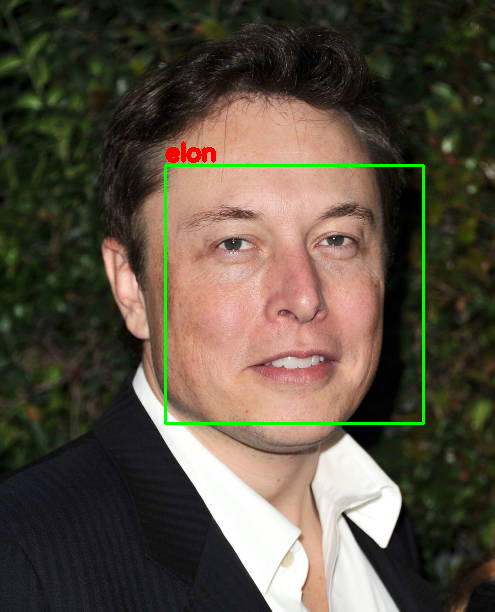

True


In [174]:
is_rec = is_image_recognized('./dataset/test/single/elon_single.jpg')
print(is_rec)